In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!git clone https://github.com/tylin/coco-caption

Cloning into 'coco-caption'...
remote: Enumerating objects: 736, done.
remote: Total 736 (delta 0), reused 0 (delta 0), pack-reused 736
Receiving objects: 100% (736/736), 130.04 MiB | 33.92 MiB/s, done.
Resolving deltas: 100% (390/390), done.


In [6]:
%cd /content/coco-caption/

/content/coco-caption


In [7]:
%matplotlib inline
from pycocotools.coco import COCO
#from pycocoevalcap.eval import COCOEvalCap
import matplotlib.pyplot as plt
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import json
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')

In [8]:
# set up file names and pathes
dataDir='.'
dataType='val2014'
algName = 'fakecap'
annFile='%s/annotations/captions_%s.json'%(dataDir,dataType)
subtypes=['results', 'evalImgs', 'eval']
[resFile, evalImgsFile, evalFile]= \
['%s/results/captions_%s_%s_%s.json'%(dataDir,dataType,algName,subtype) for subtype in subtypes]

# download Stanford models
!./get_stanford_models.sh

Downloading...
--2020-07-26 15:05:26--  http://nlp.stanford.edu/software/stanford-corenlp-full-2015-12-09.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/software/stanford-corenlp-full-2015-12-09.zip [following]
--2020-07-26 15:05:26--  https://nlp.stanford.edu/software/stanford-corenlp-full-2015-12-09.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 403157240 (384M) [application/zip]
Saving to: ‘stanford-corenlp-full-2015-12-09.zip’

stanford-corenlp-fu 100%[===================>] 384.48M  40.0MB/s    in 13s     

2020-07-26 15:05:40 (29.2 MB/s) - ‘stanford-corenlp-full-2015-12-09.zip’ saved [403157240/403157240]

Unzipping...
Archive:  stanford-corenlp-full-2015-12-09.zip
   creating: pycocoevalcap/spice/lib/st

In [9]:
# create coco object and cocoRes object
coco = COCO(annFile)
cocoRes = coco.loadRes(resFile)

loading annotations into memory...
0:00:00.676251
creating index...
index created!
Loading and preparing results...     
DONE (t=0.04s)
creating index...
index created!


In [10]:
#__author__ = 'tylin'
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

class COCOEvalCap:
    def __init__(self, coco, cocoRes):
        print('ullu')
        self.evalImgs = []
        self.eval = {}
        self.imgToEval = {}
        self.coco = coco
        self.cocoRes = cocoRes
        self.params = {'image_id': coco.getImgIds()}

    def evaluate2(self, gts, res):

        print 'tokenizationme...'

        tokenizer = PTBTokenizer()
        gts  = tokenizer.tokenize(gts)
        res = tokenizer.tokenize(res)

        # =================================================
        # Set up scorers
        # =================================================
        print 'setting up scorers...'
        scorers = [
            (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
            (Meteor(),"METEOR"),
            (Rouge(), "ROUGE_L"),
            (Cider(), "CIDEr"),
            (Spice(), "SPICE")
        ]

        # =================================================
        # Compute scores
        # =================================================
        for scorer, method in scorers:
            print 'computing %s score...'%(scorer.method())
            score, scores = scorer.compute_score(gts, res)
            if type(method) == list:
                for sc, scs, m in zip(score, scores, method):
                    self.setEval(sc, m)
                    self.setImgToEvalImgs(scs, gts.keys(), m)
                    print "%s: %0.3f"%(m, sc)
            else:
                self.setEval(score, method)
                self.setImgToEvalImgs(scores, gts.keys(), method)
                print "%s: %0.3f"%(method, score)
        self.setEvalImgs()     

    def evaluate(self):
        print("sdfsadf")
        print 'd'
        imgIds = self.params['image_id']
        # imgIds = self.coco.getImgIds()
        gts = {}
        res = {}
        a=0
        for imgId in imgIds:
            gts[imgId] = self.coco.imgToAnns[imgId]
            res[imgId] = self.cocoRes.imgToAnns[imgId]
            if(a<1):
              print('')
              print(self.coco.imgToAnns[imgId])
              print(self.cocoRes.imgToAnns[imgId])
              a+=1
              print('')
        # =================================================
        # Set up scorers
        # =================================================
        print 'tokenizationme...'

        tokenizer = PTBTokenizer()
        gts  = tokenizer.tokenize(gts)
        res = tokenizer.tokenize(res)

        # =================================================
        # Set up scorers
        # =================================================
        print 'setting up scorers...'
        scorers = [
            (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
            (Meteor(),"METEOR"),
            (Rouge(), "ROUGE_L"),
            (Cider(), "CIDEr"),
            (Spice(), "SPICE")
        ]

        # =================================================
        # Compute scores
        # =================================================
        for scorer, method in scorers:
            print 'computing %s score...'%(scorer.method())
            score, scores = scorer.compute_score(gts, res)
            if type(method) == list:
                for sc, scs, m in zip(score, scores, method):
                    self.setEval(sc, m)
                    self.setImgToEvalImgs(scs, gts.keys(), m)
                    print "%s: %0.3f"%(m, sc)
            else:
                self.setEval(score, method)
                self.setImgToEvalImgs(scores, gts.keys(), method)
                print "%s: %0.3f"%(method, score)
        self.setEvalImgs()

    def setEval(self, score, method):
        self.eval[method] = score

    def setImgToEvalImgs(self, scores, imgIds, method):
        for imgId, score in zip(imgIds, scores):
            if not imgId in self.imgToEval:
                self.imgToEval[imgId] = {}
                self.imgToEval[imgId]["image_id"] = imgId
            self.imgToEval[imgId][method] = score

    def setEvalImgs(self):
        self.evalImgs = [eval for imgId, eval in self.imgToEval.items()]

print("Done")

Done


# resutls on our dataset

In [11]:
with open('/content/drive/My Drive/Laeeq/predictedCaption.json', 'r') as file:
  jfile = json.load(file)
with open('/content/drive/My Drive/Laeeq/annotation.json', 'r') as file:
  cfile = json.load(file)

print("Files loaded")

Files loaded


In [12]:

gts={}
res = {}

for i in range(len(jfile)):
  
  tempResList = []
  
  image_id=jfile[i]['image_id']
  caption = jfile[i]['caption']
  dict1 = {'image_id' : image_id, 'id' : i, 'caption' : caption}
  tempResList.append(dict1)
  res.update({image_id: tempResList})

  tempGts = []
  for dicta in cfile:
    if(int(dicta['id']) == image_id):
      dict2 = {'image_id': image_id, 'id':i, 'caption': dicta['caption']}
      tempGts.append(dict2)
  gts.update({image_id: tempGts})
  if(i%100==0):
    print(i)

0
100
200
300
400


In [13]:
len(res), len(gts)

(485, 485)

In [14]:
# create cocoEval object by taking coco and cocoRes
cocoEval = COCOEvalCap(coco, cocoRes)

# evaluate on a subset of images by setting
# cocoEval.params['image_id'] = cocoRes.getImgIds()
# please remove this line when evaluating the full validation set
cocoEval.params['image_id'] = cocoRes.getImgIds()

# evaluate results
# SPICE will take a few minutes the first time, but speeds up due to caching
cocoEval.evaluate2(gts, res)

ullu
tokenizationme...
setting up scorers...
computing Bleu score...
{'reflen': 5089, 'guess': [5805, 5320, 4835, 4350], 'testlen': 5805, 'correct': [2282, 1238, 931, 785]}
ratio: 1.140695618
Bleu_1: 0.393
Bleu_2: 0.302
Bleu_3: 0.260
Bleu_4: 0.237
computing METEOR score...
METEOR: 0.203
computing Rouge score...
ROUGE_L: 0.408
computing CIDEr score...
CIDEr: 2.405
computing SPICE score...
SPICE: 0.315


In [15]:
# print output evaluation scores
for metric, score in cocoEval.eval.items():
    print '%s: %.2f'%(metric, score*100)

CIDEr: 240.49
Bleu_4: 23.74
Bleu_3: 26.02
Bleu_2: 30.25
Bleu_1: 39.31
ROUGE_L: 40.82
METEOR: 20.28
SPICE: 31.50


In [ ]:
# demo how to use evalImgs to retrieve low score result
evals = [eva for eva in cocoEval.evalImgs if eva['CIDEr']<30]
print 'ground truth captions'
imgId = evals[0]['image_id']
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

print '\n'
print 'generated caption (CIDEr score %0.1f)'%(evals[0]['CIDEr'])
annIds = cocoRes.getAnnIds(imgIds=imgId)
anns = cocoRes.loadAnns(annIds)
coco.showAnns(anns)

img = coco.loadImgs(imgId)[0]
I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
plt.imshow(I)
plt.axis('off')
plt.show()

ground truth captions


generated caption (CIDEr score 0.6)


KeyError: ignored

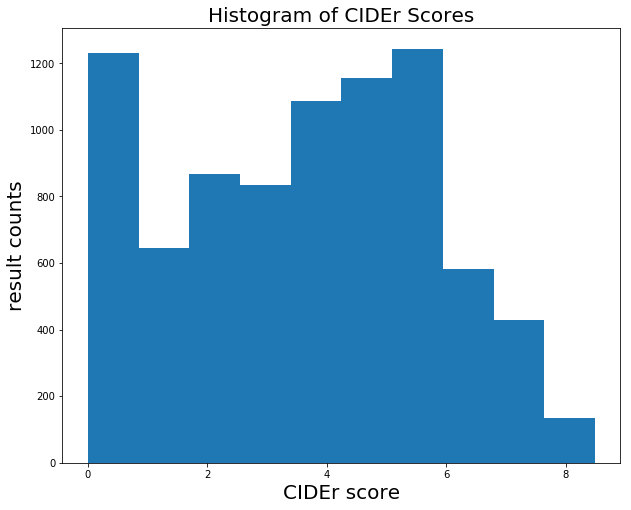

In [ ]:
# plot score histogram
ciderScores = [eva['CIDEr'] for eva in cocoEval.evalImgs]
plt.hist(ciderScores)
plt.title('Histogram of CIDEr Scores', fontsize=20)
plt.xlabel('CIDEr score', fontsize=20)
plt.ylabel('result counts', fontsize=20)
plt.show()

In [ ]:
# save evaluation results to ./results folder
json.dump(cocoEval.evalImgs, open(evalImgsFile, 'w'))
json.dump(cocoEval.eval,     open(evalFile, 'w'))

In [ ]:
184321
184321
81922
81922
577539
577539
380932
380932
204805
204805
339974
339974
153607
153607
440329
440329
310325
310325
501762
501762
419856
419856
1369
1369
234500
234500
241691

241691